# Audio Fingerprinting for Model Attribution: A Hands-On Tutorial
This tutorial will guide you through the process of determining whether a given audio sample was generated by a specific target neural speech synthesis system, using techniques based on audio fingerprinting.

We will cover:
1.   Loading and visualizing audio signals.
2.   Model-specific fingerprints.
3.   Fingerprint Extraction.
4.   Attribution: Correlation and Mahalanobis Distance.

## Preparation

This practical session uses Python, specifically Numpy, Scipy, and PyTorch, with all dependencies expected to be pre-installed in the Colab environment.

The only requirement is to download a few pre-trained models and sample data.



In [ ]:
!echo "Download external zip "
!wget --quiet --show-progress -O tutorial.zip https://www.dropbox.com/scl/fi/thzg1pxy1ke1f4onmb9r4/tutorial.zip?rlkey=2trnij764jjvun1rvlsetadf0&st=uu9j9dlk&dl=1
!echo "Unzip files"
!unzip -q -o tutorial.zip -x / -d /content
!if [ -d "/content/tutorial" ]; then echo "Done"; else echo "Please contact with the author"; fi


Download external zip 
tutorial.zip        100%[===================>]   6.21M  23.9MB/s    in 0.3s    
Unzip files
caution: excluded filename not matched:  /
Done


In [ ]:
# !rm -rf /content/tutorial


Audio samples in this tutorial come from:

- **WaveFake Corpus**:
 Licensed under the MIT License. © 2021 Ruhr University Bochum.  
  Permission is granted to use, copy, modify, and distribute the software under the terms of the MIT License.  
  Source: [WaveFake GitHub Repository](https://github.com/RUB-SysSec/WaveFake)
- **LJ Speech Dataset**:
  This dataset is in the public domain in the US and likely other countries.
  There are no restrictions on its use.  
  Source: [LJ Speech Dataset](https://keithito.com/LJ-Speech-Dataset/)


## 1. Load and Listen to Audio
We begin processing audio, let's start by uploading a .wav file.
This is useful if you want to test your own recordings or custom audio samples.

Let’s load it and listen to it using PyTorch's torchaudio and IPython:


In [ ]:
import torchaudio
import IPython.display as ipd

# Loading audio file
audio_path = 'tutorial/real/LJ001-0005.wav'
waveform, sample_rate = torchaudio.load(audio_path)

# waveform shape: [channels, samples]
duration = waveform.shape[1] / sample_rate
print(f"Audio duration: {duration:.2f} seconds, Sample rate: {sample_rate} Hz")

# Listening to audio
ipd.Audio(waveform[0].numpy(), rate=sample_rate)

Audio duration: 8.11 seconds, Sample rate: 22050 Hz


### Plot the Spectrogram
A spectrogram is a visual representation of the range of frequencies in a signal as it changes over time. It is commonly used in audio processing and speech recognition to analyze frequency content and patterns, such as pitch, harmonics, or phonemes.

To generate a spectrogram, we apply the Short-Time Fourier Transform (STFT) to the waveform. STFT breaks the audio into overlapping chunks (windows) and performs a Fourier transform on each, resulting in a time-frequency representation.

This code uses torchaudio and matplotlib to compute and plot spectrograms with different configurations:

In [ ]:
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import torch

def plot_spectrogram(waveform, sample_rate, n_fft=1024, hop_length=256, title=None):
  """
  Compute and plot a spectrogram using torch's STFT.

  Args:
      waveform (Tensor): Audio tensor of shape [1, T] or [C, T]
      sample_rate (int): Sampling rate of the waveform
      n_fft (int): Size of FFT window (affects frequency resolution)
      hop_length (int): Step size between windows (affects time resolution)
      title (str): Optional plot title
  """

  # Ensure mono
  if waveform.shape[0] > 1:
      waveform = waveform.mean(dim=0, keepdim=True)

  transform = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2)
  spec = transform(waveform)
  spec_db = 10 * torch.log10(spec + 1e-10)

  plt.figure(figsize=(8, 3))
  plt.imshow(
      spec_db[0].numpy(),
      aspect='auto',
      origin='lower',
      extent=[0, waveform.shape[1] / sample_rate, 0, sample_rate // 2]
  )
  plt.colorbar(format='%+2.0f dB')
  plt.title(title or f"Spectrogram (n_fft={n_fft}, hop_length={hop_length})")
  plt.xlabel("Time (s)")
  plt.ylabel("Frequency (Hz)")
  plt.tight_layout()
  plt.show()

In this step, we ensure that the audio is mono (single channel), as many audio analysis methods assume this format for simplicity and consistency.

Each call to plot_spectrogram shows a different time-frequency resolution:

* n_fft controls the frequency resolution. Larger values allow you to see finer frequency details.
* hop_length controls the time resolution. Smaller values provide finer temporal details but increase computational cost.

By varying these parameters, we can gain different perspectives on the spectral content of the audio — a useful step before fingerprinting.



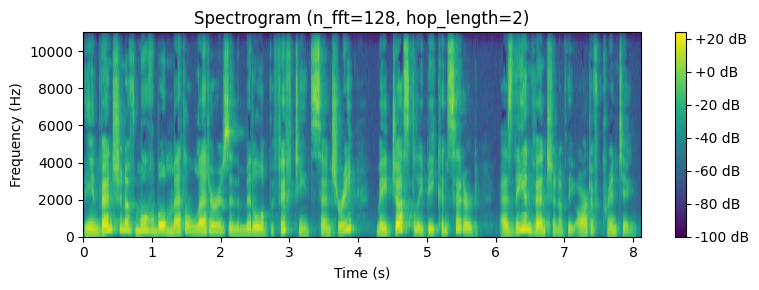

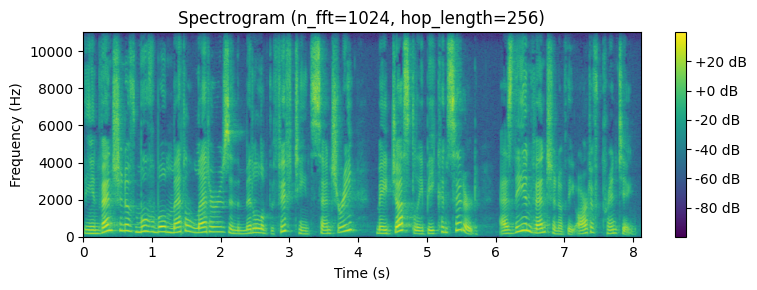

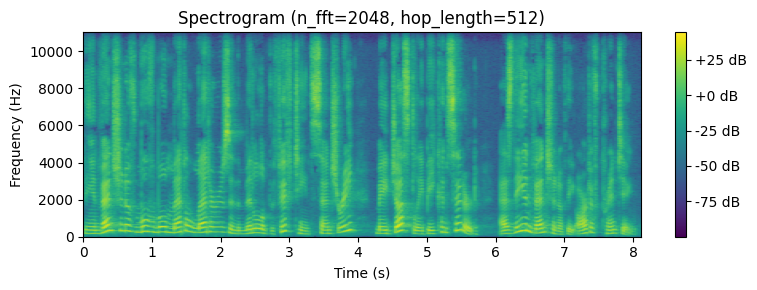

In [ ]:
import IPython.display as ipd

# Loading audio file
audio_path = 'tutorial/real/LJ001-0005.wav'
waveform, sample_rate = torchaudio.load(audio_path)

# Convert to mono if needed
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

# n_fft: Determines the frequency resolution. Larger values capture finer frequency detail.
# hop_length: Controls time resolution (step size between windows). Smaller values give better time granularity.
# Example usage with your waveform
plot_spectrogram(waveform, sample_rate, n_fft=128, hop_length=2)
plot_spectrogram(waveform, sample_rate, n_fft=1024, hop_length=256)
plot_spectrogram(waveform, sample_rate, n_fft=2048, hop_length=512)

When we compute a spectrogram, we are usually calculating the power (or magnitude squared) of the signal at different frequencies over time.
However, these raw power values can vary by several orders of magnitude, making them difficult to interpret and visualize.
To solve this, we convert the power spectrogram to a decibel (dB) scale, which compresses the dynamic range, makes the plot more visually informative, and matches how humans perceive loudness (we hear in a logarithmic scale).

When plotting the spectrogram, the frequency axis (Y-axis) typically ranges from 0 Hz to half the sampling rate. This is due to the Nyquist Theorem, which states that the maximum frequency that can be represented in a digital signal is half the sample rate (sr / 2).
This upper limit is called the Nyquist frequency. Frequencies above this are redundant due to the symmetry of the Fourier transform when applied to real-valued signals.
For example, if your audio is sampled at 22,050 Hz, the spectrogram will only show frequencies up to 11,025 Hz.

 ### Try It Yourself!
 Now that you've seen how to compute and visualize spectrograms, try experimenting with different audio files!

To try this with a different audio file, simply change the value of audio_path in the cell above to point to another .wav file, and then re-run the entire cell to update both the waveform and its spectrograms.
Suggested files to try:
* LJ001-0013.wav
* LJ001-0036.wav
* LJ001-0058.wav

## 2. Model-specific fingerprints
The concept of model-specific fingerprints was initially explored by [Marra et al.](https://arxiv.org/abs/1812.11842) in the context of image generation using Generative Adversarial Networks (GANs).   
Their idea is based on the assumption that any artificially generated image $x$ decomposes into its content $I(x)$ and a fingerprint $F$ that is unrelated to the image semantics but specific to the model, that is,
\begin{equation*}
x = I(x) + F
\end{equation*}
for every $x$ generated from the model.  
To extract the fingerprint, they assumed that a suitable image filter $f$ is capable of removing the fingerprint, such that $f(x) \approx I(x)$, and therefore the residual
\begin{equation*}
R := x - f(x) \approx F.
\end{equation*}
Given a set of generated samples $x_1, \dots, x_N$, the sample-wise residuals are defined by $R_i:= x_i - f(x_i)$ and $F$ is estimated by
\begin{equation*}
\hat{F}:= \frac{1}{N}\sum_{i=1}^N R_i.
\end{equation*}
For inference, i.e., for checking whether a test sample $x_{\operatorname{test}}$ contains a fingerprint similar to $\hat{F}$, they first compute its residual $R_{\operatorname{test}}$ as above and then assign an attribution score $s_{\operatorname{attr}}(R_{\operatorname{test}}; \, \hat{F}) $, that could be for example the Pearson correlation.

Unlike images, audio signals pose unique challenges for fingerprint extraction.
This task presents two main challenges that distinguish audio fingerprinting from its image counterpart:

a) Variable-length: Unlike fixed-size images, audio signals vary in duration, but fingerprint extraction requires a fixed-size representation for consistent analysis.

b) Content-preserving filtering: While image fingerprints rely on spatial filtering, audio requires filters that suppress content-related features such as speech semantics and phonetics, while preserving subtle generative model-specific artifacts.


### a) Fixed-size Representation
To handle the variable length of audio signals, we convert each signal into a fixed-size representation that summarizes its spectral content over time.
We apply the Short-Time Fourier Transform (STFT) to compute a spectrogram — a time-frequency representation showing how energy is distributed across frequencies and time. Then, we average the energy values across the time axis for each frequency bin. This results in a single value per frequency bin, representing its average energy over the entire duration of the audio.

This fixed-size vector serves as a compact summary of the audio’s frequency profile.

In [ ]:
import torchaudio.transforms as T

audio_path = 'tutorial/real/LJ001-0005.wav'
waveform, sample_rate = torchaudio.load(audio_path)

# Compute the spectrogram
transform = T.Spectrogram(n_fft=2048, hop_length=128)
spec = transform(waveform)
spec = 10. * torch.log(spec + 10e-13)
print("Spectrogram shape:", spec.shape)
# Average over time axis (dim=2) to get a single vector per channel
bin_data = torch.nanmean(spec, dim=2)
print("Averaged bin data shape:", bin_data.shape)


Spectrogram shape: torch.Size([1, 1025, 1398])
Averaged bin data shape: torch.Size([1, 1025])


Try analyzing a different audio file, such as LJ001-0013.wav, which has a different duration but the same sampling rate.

You'll notice that the time dimension of the spectrogram changes with the audio length — longer audio results in more time frames.

However, the number of frequency bins remains constant, because it is determined by the n_fft parameter, which controls the frequency resolution and is independent of the audio duration.

### b) Suitable Filtering Methods
To isolate generative artifacts, we apply content-preserving filters to the audio signal before computing the residuals of our spectral energy representation.
We investigate two types of filtering approaches: (1) neural compression using Encodec, and (2) low-pass filtering.

**EnCodec:** It is a machine learning model designed to compress and decompress audio — much like how ZIP files or MP3s work, but using deep learning.
It does this by learning how to represent audio using a much smaller set of data (a compressed version) without losing too much quality. This compressed version is called a latent representation. EnCodec can then reconstruct the original audio from this compressed form.

Run the following cell before importing anything from EnCodec:

In [ ]:
!pip install -q encodec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 57.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00


The apply_encodec function compresses and decompresses an audio waveform using EnCodec neural audio codec at a specified bitrate (default 24 kbps). It ensures the input is mono, resamples it to 24 kHz (as required by the model), and passes it through the codec to simulate reconstruction after compression. The output is then resampled back to the original sample rate if necessary. This process helps evaluate how EnCodec alters the audio signal, which is useful in tasks like fingerprinting or model attribution where subtle differences in audio may be significant.

In [ ]:
from encodec import EncodecModel

def apply_encodec(waveform, sample_rate, target_bitrate_kbps=24):
    """
    Compress and decompress a waveform using EnCodec (24kHz mono).

    Args:
        waveform (Tensor): Input waveform of shape [1, T] or [C, T] where C=1.
        sample_rate (int): Sample rate of the input waveform.
        target_bitrate_kbps (int): Target bitrate in kbps (default is 24).

    Returns:
        Tensor: Reconstructed waveform at the original sample rate.
    """
    # Ensure waveform is mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Load EnCodec model
    model = EncodecModel.encodec_model_24khz()
    model.set_target_bandwidth(target_bitrate_kbps)
    model.eval()

    # Resample to 24 kHz
    if sample_rate != model.sample_rate:
        resample_to_24k = torchaudio.transforms.Resample(sample_rate, model.sample_rate)
        waveform = resample_to_24k(waveform)

    # Prepare for model input
    waveform = waveform.unsqueeze(0)  # Shape: [1, 1, T]

    # Encode and decode (no gradients needed)
    with torch.no_grad():
        reconstructed = model(waveform)

    # Remove batch dimension
    reconstructed = reconstructed.squeeze(0)

    # Resample back to original sample rate
    if model.sample_rate != sample_rate:
        resample_to_orig = torchaudio.transforms.Resample(model.sample_rate, sample_rate)
        reconstructed = resample_to_orig(reconstructed)

    return reconstructed

Let's compare the frequency content of the original and the processed (e.g., compressed or resynthesized) audio signals using spectrograms.

What do you observe?

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /root/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th
100%|██████████| 88.9M/88.9M [00:00<00:00, 154MB/s]


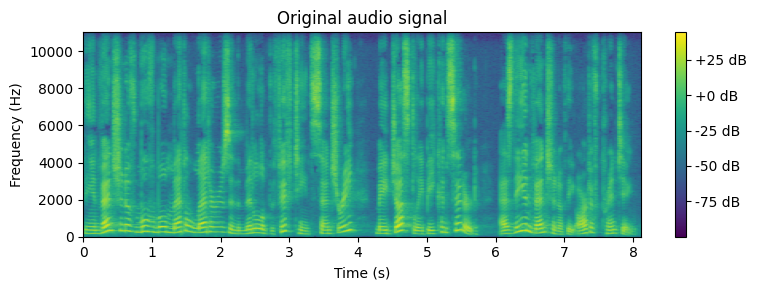

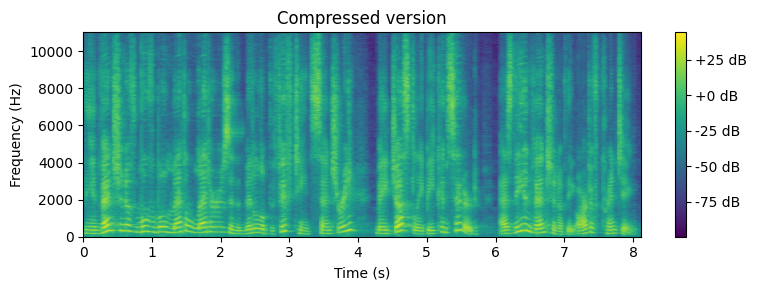

In [ ]:
from IPython.display import display, Audio

# Load audio
waveform, sample_rate = torchaudio.load('tutorial/real/LJ001-0005.wav')

# Apply EnCodec compression-decompression
output = apply_encodec(waveform, sample_rate)

# Plot or listen
plot_spectrogram(waveform, sample_rate, n_fft=2048, hop_length=512, title="Original audio signal")
display(Audio(waveform[0].numpy(), rate=sample_rate))

plot_spectrogram(output, sample_rate, n_fft=2048, hop_length=512, title="Compressed version")
display(Audio(output[0].numpy(), rate=sample_rate))

**Low-pass filter:**
This filter method retains only the low-frequency content below the cutoff, potentially emphasizing system-specific spectral characteristics in the lower bands.
We evaluate the filters using cutoff frequency of 1 kHz, with a stopband frequency at 1.5 kHz.

This filter operates by convolving the input signal with a set of learned or designed filter coefficients.
Given a discrete-time input signal $ x^{(i)} = \{x^{(i)}_1, x^{(i)}_2, \dots, x^{(i)}_s\} $, the filtered output $ y^{(i)} = \{y^{(i)}_1, y^{(i)}_2, \dots, y^{(i)}_s\} $ is obtained via convolution:
\begin{equation*}
y^{(i)}_n = \sum_{k=0}^{K-1} h_k \cdot x^{(i)}_{n-k}, \quad \text{for } n = 1, \dots, s \enspace ,
\end{equation*}
where $ h_k $ are the filter coefficients, and $ K $ is the filter order, i.e., the number of coefficients in the filter.
This corresponds to a standard 1D convolution operation with one input and one output channel.
Reflect padding is applied to ensure the output has the same length as the input, reducing boundary artifacts.

The apply_fir_filter function applies a Finite Impulse Response (FIR) filter to a mono audio waveform using 1D convolution. It first checks that the input has the correct shape [1, N], then creates a convolution kernel from the provided filter coefficients. To preserve the original waveform length after filtering, it pads the signal using reflection padding. The function then performs the convolution using PyTorch’s conv1d, returning the filtered waveform with the same shape as the input.

In [ ]:
import torch.nn.functional as F

def apply_fir_filter(waveform: torch.Tensor, coeffs: list[float]) -> torch.Tensor:
    """
    Apply a FIR filter to an audio waveform using 1D convolution.

    Args:
        waveform (Tensor): Shape (1, N) for mono waveform.
        coeffs (list of float): FIR filter coefficients.

    Returns:
        filtered waveform (Tensor): Shape (1, N) after filtering.
    """
    if waveform.ndim != 2 or waveform.shape[0] != 1:
        raise ValueError("Waveform must be mono (shape [1, N])")

    # Prepare kernel
    fir_kernel = torch.tensor(coeffs, dtype=torch.float32).view(1, 1, -1)
    kernel_size = fir_kernel.shape[2]

    # Pad to maintain output size
    pad = kernel_size // 2
    padded = F.pad(waveform, (pad, pad), mode='reflect')

    # Apply filter
    filtered = F.conv1d(padded.unsqueeze(0), fir_kernel).squeeze(0)

    return filtered

The following code loads FIR filter coefficients from a text file and applies them to an audio waveform using the apply_fir_filter function. It first reads the coefficients from lpf_1khz.txt, loads a mono version of the audio file LJ001-0005.wav, and then filters the signal to attenuate certain frequency components based on the FIR design. After filtering, it visualizes the result as a spectrogram and plays back the processed audio so you can both see and hear the effect of the filtering.

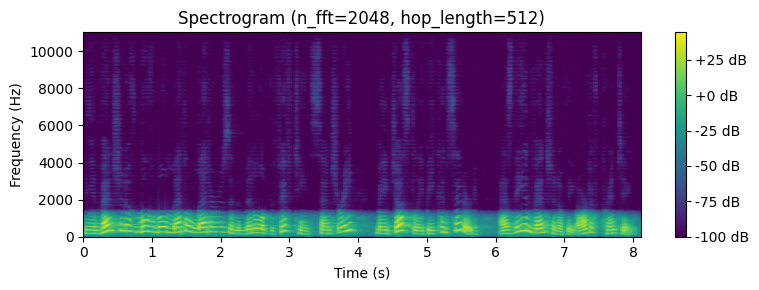

In [ ]:
# Load coefficients
with open('tutorial/fingerprints/low_pass_filter/lpf_1khz.txt', 'r') as f:
    coeffs = [float(line.strip()) for line in f if line.strip()]

# Load waveform
waveform, sample_rate = torchaudio.load('tutorial/real/LJ001-0005.wav')
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

# Apply filter
filtered_waveform = apply_fir_filter(waveform, coeffs)

# Visualize and listen
plot_spectrogram(filtered_waveform, sample_rate, n_fft=2048, hop_length=512)
ipd.Audio(filtered_waveform.numpy(), rate=sample_rate)

What differences do you observe in the spectrogram before and after filtering?

How has the filter affected the high-frequency content of the signal?

## 3. Fingerprint Extraction


As an example, we will calculate an ***ideal*** residual by comparing the original real speech with its AI-generated counterpart and visualize how the residuals differ depending on the model used.

This function computes the difference in average spectral energy between an original and an AI-generated audio file by first loading and converting both to mono, then verifying their sample rates match. It computes spectrograms for each using the specified FFT and hop length parameters, converts them to decibel scale, and averages the spectral energy over time for each frequency bin. Finally, it returns the sample rate along with the element-wise difference between the original and AI-generated average spectral energies, highlighting frequency-based residual differences between the two signals.

In [ ]:
from matplotlib.ticker import FixedLocator, FixedFormatter
import numpy as np

def compute_bin_residual(original_audio_path, ai_audio_generated_path, n_fft=2048, hop_length=128):
    waveform_orig, sr_orig = torchaudio.load(original_audio_path)
    waveform_ai, sr_ai = torchaudio.load(ai_audio_generated_path)

    if waveform_orig.shape[0] > 1:
        waveform_orig = waveform_orig.mean(dim=0, keepdim=True)
    if waveform_ai.shape[0] > 1:
        waveform_ai = waveform_ai.mean(dim=0, keepdim=True)

    if sr_orig != sr_ai:
        raise ValueError("Sample rates do not match.")

    transform = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec_orig = transform(waveform_orig)
    spec_ai = transform(waveform_ai)

    spec_orig_db = 10. * torch.log10(spec_orig + 1e-10)
    spec_ai_db = 10. * torch.log10(spec_ai + 1e-10)

    bin_data_orig = torch.nanmean(spec_orig_db, dim=2).squeeze(0).numpy()
    bin_data_ai = torch.nanmean(spec_ai_db, dim=2).squeeze(0).numpy()

    return sr_orig, bin_data_orig - bin_data_ai

The function plot_all_residuals takes pairs of original and AI-generated audio files, computes the spectral residuals for each pair using compute_bin_residual, and plots them in a 2x2 grid of bar charts. Each subplot shows the difference in average spectral energy across frequency bins (in kHz) between the original and AI audio generated, with consistent y-axis limits for easy comparison. The x-axis is labeled with fixed frequency ticks, and each plot is titled according to the provided labels, allowing visual analysis of frequency-specific discrepancies across multiple audio samples.

In [ ]:
def plot_all_residuals(audio_pairs, titles, n_fft=2048, hop_length=128):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    residuals = []
    sample_rates = []

    # Compute all residuals first
    for orig, ai in audio_pairs:
        sr, residual = compute_bin_residual(orig, ai, n_fft, hop_length)
        residuals.append(residual)
        sample_rates.append(sr)

    # Ensure all plots have same y-axis range
    all_values = np.concatenate(residuals)
    y_min, y_max = all_values.min(), all_values.max()

    for i, ax in enumerate(axes):
        freqs = np.linspace(0, sample_rates[i] / 2, len(residuals[i])) / 1000  # kHz

        tick_positions = np.arange(0, sample_rates[i] / 2000 + 0.1, 2)
        ax.xaxis.set_major_locator(FixedLocator(tick_positions))
        ax.xaxis.set_major_formatter(FixedFormatter([f"{x:.0f}" for x in tick_positions]))

        ax.bar(x=freqs, height=residuals[i], width=freqs[1]-freqs[0], color="#2D5B68")
        ax.set_ylim(y_min, y_max)

        ax.set_title(titles[i], fontsize=12)
        ax.set_xlabel("Frequency (kHz)", fontsize=10)
        ax.set_ylabel("Residual Energy (dB)", fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=9)

    fig.tight_layout(pad=2.0)
    plt.show()

This example defines four pairs of audio files, each consisting of an original real audio sample and its corresponding AI-generated version from different models. The plot_all_residuals function is then called with these pairs and titles to visualize and compare the spectral residuals—differences in frequency content—between the real audio and each AI-generated version, helping to assess how each model’s output differs from the original.

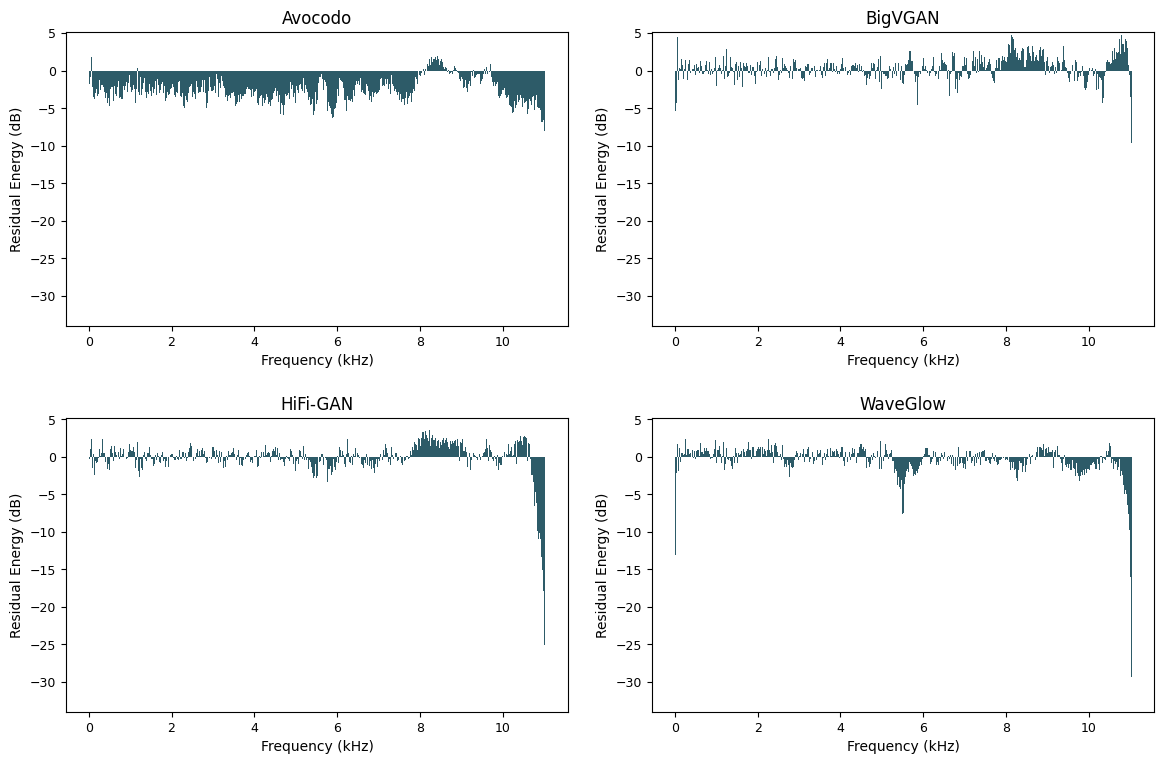

In [ ]:
# Example usage:
audio_pairs = [
    ('tutorial/real/LJ001-0005.wav', 'tutorial/avocodo/LJ001-0005.wav'),
    ('tutorial/real/LJ001-0005.wav', 'tutorial/bigvgan/LJ001-0005.wav'),
    ('tutorial/real/LJ001-0005.wav', 'tutorial/hifiGAN/LJ001-0005.wav'),
    ('tutorial/real/LJ001-0005.wav', 'tutorial/waveglow/LJ001-0005.wav'),
]
titles = ['Avocodo', 'BigVGAN', 'HiFi-GAN', 'WaveGlow']

plot_all_residuals(audio_pairs, titles)

* What unique spectral fingerprints or residual patterns does each AI-generated model (e.g., Avocodo, BigVGAN, HiFi-GAN, WaveGlow) leave behind compared to real speech?

* Are there specific frequency bands where differences are more pronounced for certain models?

* Can these residual patterns be reliably used to identify which model generated a given audio sample?

Try experimenting with different audio files such as LJ001-0013.wav, LJ001-0036.wav, and LJ001-0058.wav to explore these questions.

## Residual-Based Fingerprinting of AI-Generated Speech in Realistic Settings
In real-world scenarios, we often do not have access to the original (real) audio that an AI model used as input to generate speech.
This poses a challenge when trying to detect or attribute synthesized audio to a specific model.

To address this, we instead apply a filter—such as a low-pass filter or a learned model like EnCodec—to the AI-generated audio.
We then apply the Short-Time Fourier Transform (STFT) and compute the average energy per frequency bin for both the given audio signal and its filtered counterpart.
Finally, we compute the residual, which serves as a proxy for the model's fingerprint.

We estimate the generative model’s fingerprint $ \hat{\mathcal{F}} $ by averaging the residuals between the training audio samples and their filtered versions:
\begin{equation}
\hat{F} := \frac{1}{N} \sum_{i=1}^N \mathcal{R}^{(i)} \enspace , \quad \text{where } \mathcal{R}^{(i)} := E_{x^{(i)}} - E_{f(x^{(i)})} \enspace .
\end{equation}

Here, $ f(\cdot) $ denotes the chosen filter (e.g., EnCodec or low pass filter), $ E $ summarizes the spectral energy distribution across time, and $ \mathcal{R}^{(i)} $ is the residual vector for signal $ x^{(i)} $.

Example: Residual Calculation using EnCodec Filtering

This function computes the residual spectral energy between an original waveform and its filtered version, which serves as a signature of how a given filtering process (like EnCodec compression or low-pass filtering) alters the signal. It first applies the specified filter function—either a neural codec (e.g., EnCodec) or a classical filter—then computes spectrograms for both the original and filtered audio. By converting the spectrograms to decibel scale and averaging the difference across the time axis, it produces a single vector representing the average energy discrepancy per frequency bin, capturing how much spectral information is lost or changed by the filtering process.

In [ ]:
# Load pretrained 24kHz mono EnCodec model

def compute_residual(waveform, filter_function, filter_fn_param=None, n_fft=2048, hop_length=128):

    # Apply filter function
    output = filter_function(waveform, filter_fn_param)

    # Compute spectrograms
    spec_fn = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec_orig = spec_fn(waveform)
    spec_recon = spec_fn(output)

    # Convert to dB
    spec_orig_db = 10. * torch.log10(spec_orig + 1e-10)
    spec_recon_db = 10. * torch.log10(spec_recon + 1e-10)

    E_residual = spec_orig_db - spec_recon_db
    # Average over time
    residual = torch.nanmean(E_residual, dim=2).squeeze(0).numpy()

    return residual

This code computes and visualizes the spectral differences between an AI-generated audio sample and its EnCodec-compressed version, highlighting the frequency bands most affected by the model.

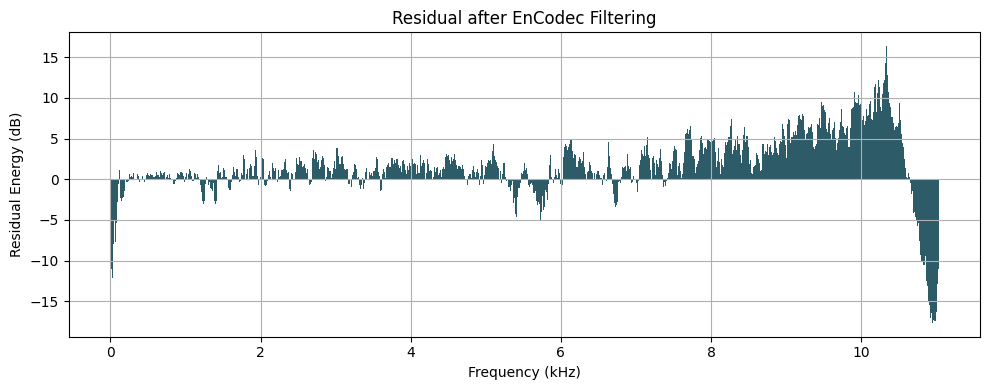

In [ ]:
# Load an AI-generated audio
waveform, sr = torchaudio.load('tutorial/bigvgan/LJ001-0005.wav')

# Example usage
residual = compute_residual(waveform, apply_encodec, sr, n_fft=2048, hop_length=128)

# Plot
freqs = np.linspace(0, sr // 2, len(residual)) / 1000  # in kHz
plt.figure(figsize=(10, 4))
plt.bar(freqs, residual, width=freqs[1]-freqs[0], color="#2D5B68")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Residual Energy (dB)")
plt.title("Residual after EnCodec Filtering")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Exercise: Residual Estimation via Low-Pass Filtering.

As an exercise, replicate the residual estimation process using a low-pass filter function instead of a learned codec like EnCodec. Compute log-scale spectrograms of both the given AI-generated audio signal and its filtered counterpart using n_fft=128 and hop_length=2.

In [ ]:
# Load an AI-generated audio

# Example usage

# Plot


## 4. Attribution: Correlation and Mahalanobis Distance
Constructing a reliable fingerprint associated with an AI-generated model requires many audio samples.
This is because individual residuals can vary due to content or noise, so we average residuals over multiple samples to obtain a stable representation of the model’s behavior.

To simplify this tutorial, we will use precomputed (pre-trained) fingerprints for four generative models, allowing us to focus on the attribution logic rather than fingerprint estimation.

### How do we attribute a test sample?
Once fingerprints are available, we want to determine which model most likely generated a given test residual $ \mathcal{R}_{\mathrm{test}} $.

Two common approaches are:

1. Pearson Correlation:
This method measures the alignment between the test residual vector and each fingerprint:
\begin{equation*}
s_{\operatorname{cor}}(\mathcal{R}_{\operatorname{test}}; \, \hat{F}) := \langle \tilde{R}_{\operatorname{test}} \, , \, \tilde{F}  \rangle \in [-1, 1] \enspace ,
\end{equation*}
where $\tilde{R}_{\operatorname{test}}$ and $\tilde{F}$ denote the zero-mean and unit-norm versions of $R_{\operatorname{test}}$ and $\hat{F}$, respectively.

* A higher score means the test residual is more similar in shape to the fingerprint.
* Attribution is done by selecting the fingerprint with the highest correlation.

2. Mahalanobis Distance:
This method takes into account not just the difference but also the variance structure of the fingerprint distribution:
\begin{equation*}
s_{\operatorname{md}}(\mathcal{R}_{\mathrm{test}}, \hat{F}) := \sqrt{ (\mathcal{R}_{\mathrm{test}} - \hat{F} )^\top \Sigma^{-1} (\mathcal{R}_{\mathrm{test}} - \hat{F} ) } \enspace ,
\end{equation*}
where $ \Sigma^{-1} $ is the inverse covariance matrix of the training residuals.
This distance accounts for feature variance and correlation, enabling more robust attribution.
* A lower distance indicates a closer match.
* Attribution is done by selecting the fingerprint with the lowest Mahalanobis distance.

#### Model attribution example
Suppose we have fingerprints for four AI-generated models such as Avocodo, BigVGAN, HiFi-GAN, and WaveGlow. Let's attribute a test sample to the most likely model based on the correlation score.

First, construct a dictionary that maps model names to the paths of their corresponding fingerprint files, depending on the specified filtering method—either "encodec" or "low_pass_filter". For EnCodec, it associates each model with a single .pickle file containing its fingerprint. For the low-pass filter method, it associates each model with two files: one containing the fingerprint and another with the inverse covariance matrix used for Mahalanobis distance scoring. This organized structure enables efficient lookup of model-specific fingerprint data for attribution tasks.

In [ ]:
from typing import List, Dict

def generate_fingerprint_dict(filtering_function: str, model_list: List[str]) -> Dict[str, Dict[str, str] | str]:
    base_dir = "tutorial/fingerprints"
    result = {}

    if filtering_function == "encodec":
        for model in model_list:
            path = f"{base_dir}/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_{model}.pickle"
            result[model] = path

    elif filtering_function == "low_pass_filter":
        for model in model_list:
            fingerprint_path = f"{base_dir}/low_pass_filter/param=1_score=mahalanobis_nfft=128_hoplen=2_fingerprint_{model}.pickle"
            invcov_path = f"{base_dir}/low_pass_filter/param=1_score=mahalanobis_nfft=128_hoplen=2_invcov_{model}.pickle"
            result[model] = {
                "fingerprint": fingerprint_path,
                "invcov": invcov_path
            }

    else:
        raise ValueError(f"Unknown filtering function: {filtering_function}")

    return result


In [ ]:
model_list = ['avocodo', 'bigvgan', 'hifigan', 'waveglow']

encodec_dict = generate_fingerprint_dict("encodec", model_list)
print("Encodec Fingerprint Paths:")
for model, path in encodec_dict.items():
    print(f"{model}: {path}")

lowpass_dict = generate_fingerprint_dict("low_pass_filter", model_list)
print("\nLow Pass Filter Fingerprint Paths:")
for model, paths in lowpass_dict.items():
    print(f"{model}:")
    print(f"  Fingerprint: {paths['fingerprint']}")
    print(f"  Invcov:      {paths['invcov']}")


Encodec Fingerprint Paths:
avocodo: tutorial/fingerprints/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_avocodo.pickle
bigvgan: tutorial/fingerprints/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_bigvgan.pickle
hifigan: tutorial/fingerprints/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_hifigan.pickle
waveglow: tutorial/fingerprints/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_waveglow.pickle

Low Pass Filter Fingerprint Paths:
avocodo:
  Fingerprint: tutorial/fingerprints/low_pass_filter/param=1_score=mahalanobis_nfft=128_hoplen=2_fingerprint_avocodo.pickle
  Invcov:      tutorial/fingerprints/low_pass_filter/param=1_score=mahalanobis_nfft=128_hoplen=2_invcov_avocodo.pickle
bigvgan:
  Fingerprint: tutorial/fingerprints/low_pass_filter/param=1_score=mahalanobis_nfft=128_hoplen=2_fingerprint_bigvgan.pickle
  Invcov:      tutorial/fingerprints/low_pass_filter/param=1_score=mahalanobis_nfft=128_hoplen=2_invcov_bigvgan.pickle
hifigan:
  Fing

Second, attribution functions are defined to quantitatively compare the residual representation of a test audio sample against target model fingerprints. The correlation_score function measures similarity by computing the inner product between the residual and the fingerprint—ideal for EnCodec-based attribution. The mahalanobis_distance function computes the statistical distance between the residual and the fingerprint using a precomputed inverse covariance matrix, suitable for low-pass filter attribution. Additionally, the zero_mean_unit_norm function is used to normalize tensors by centering and scaling them, which helps ensure consistency and comparability across residual vectors.

In [ ]:
# === Scoring Functions ===
def correlation_score(fingerprint, input_residual):
    fingerprint = fingerprint.squeeze(0)
    return torch.inner(input_residual.cpu(), fingerprint.cpu())

def mahalanobis_distance(fingerprint, residual, invcov):
    delta = residual.cpu().flatten() - fingerprint.cpu().flatten()
    distance = torch.sqrt(torch.dot(delta, torch.matmul(invcov.cpu(), delta)))
    return distance

def zero_mean_unit_norm(array: torch.tensor) -> torch.tensor:
      array = array - torch.mean(array)
      return array / torch.norm(array)

Third, the attribute_sample function performs the core attribution step by comparing the residual fingerprint of a test audio sample against fingerprints of various known generative models. It first loads the test waveform and then, for each model, computes a residual representation using either the EnCodec or low-pass filter method—depending on the filter_param. For EnCodec, it uses correlation scoring after normalizing both the residual and fingerprint; for low-pass filtering, it uses the Mahalanobis distance based on precomputed fingerprints and inverse covariance matrices. The function calculates and returns attribution scores for each candidate model, showing how likely it is that each model generated the input audio.

In [ ]:
import os
import pickle

def attribute_sample(
    test_audio_path: str,
    fingerprint_dict: dict,
    filter_param: str,
    coeffs = None
):
    """
    test_audio_path: path to the WAV file to process
    fingerprint_dict: dictionary structured as:
        - encodec: { model: path_str }
        - low_pass_filter: { model: { "fingerprint": path_str, "invcov": path_str } }
    filter_param: "encodec" or "low_pass_filter"
    sr: sample rate (only for encodec)
    coeffs: FIR coefficients (only for low_pass_filter)
    """
    scores = {}
    waveform, sr = torchaudio.load(test_audio_path)

    for model, data in fingerprint_dict.items():
        # --- ENCODEC ---
        if filter_param == "encodec":
            path_fp = data  # string

            with open(path_fp, 'rb') as f:
                fingerprint = pickle.load(f)

            # Residual for encodec
            residual = compute_residual(
                waveform,
                apply_encodec,
                sr,
                n_fft=2048,
                hop_length=128
            )
            residual = torch.from_numpy(residual)
            # Normalizing
            residual = zero_mean_unit_norm(residual)
            fingerprint = zero_mean_unit_norm(fingerprint)

            score = correlation_score(fingerprint, residual)

        # --- LOW PASS FILTER ---
        elif filter_param == "low_pass_filter":
            path_fp   = data["fingerprint"]
            path_icov = data["invcov"]
            print(f"Fingerprint path: {path_fp}")
            print(f"Inverse covariance path: {path_icov}")
            with open(path_fp, 'rb') as f:
                fingerprint = pickle.load(f)
            with open(path_icov, 'rb') as f:
                invcov = pickle.load(f)

            residual = compute_residual(
                waveform,
                apply_fir_filter,
                coeffs,
                n_fft=128,
                hop_length=2
            )
            residual = torch.from_numpy(residual)
            # Note: assuming zero_mean_unit_norm does not apply here
            score = mahalanobis_distance(fingerprint, residual, invcov)

        else:
            raise ValueError(f"Invalid filter parameter: {filter_param!r}")

        scores[model] = score.item()
        print(f"Score for {model}: {scores[model]:.4f}")

    return scores

This example demonstrates how to generate a dictionary of EnCodec fingerprint file paths for several models as we did before, and then compute attribution scores for a test audio sample using the EnCodec filtering method, identifying which model most likely generated the sample.

In [ ]:
# === Example Usage ===
test_sample = 'tutorial/avocodo/LJ001-0005.wav'
model_list = ['avocodo', 'bigvgan', 'hifiGAN', 'waveglow']
filter_param = "encodec"

filter_opt_dict = generate_fingerprint_dict("encodec", model_list)
for model, path in filter_opt_dict.items():
    print(f"{model}: {path}")

print(f"Test sample generated using {os.path.basename(os.path.dirname(test_sample))} Model")
scores = attribute_sample(test_sample, filter_opt_dict, filter_param)


avocodo: tutorial/fingerprints/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_avocodo.pickle
bigvgan: tutorial/fingerprints/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_bigvgan.pickle
hifiGAN: tutorial/fingerprints/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_hifiGAN.pickle
waveglow: tutorial/fingerprints/encodec/param=24.0_score=correlation_nfft=2048_hoplen=128_waveglow.pickle
Test sample generated using avocodo Model


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Score for avocodo: 0.9642
Score for bigvgan: 0.9086
Score for hifiGAN: 0.7726
Score for waveglow: 0.8583


You get a score for each model—so, which model most likely generated the test audio based on these scores?

For this task, change the test_sample variable to use an audio file generated by a model other than Avocodo (e.g., BigVGAN, HiFi-GAN, or WaveGlow), and make sure to use the low-pass filter fingerprint corresponding to the Avocodo model. Your goal is to observe whether the Mahalanobis distance is lowest when the test sample actually comes from Avocodo. Repeat this process with different test samples to assess whether the low-pass filter fingerprint can reliably attribute audio to the correct generative model.

In [ ]:
test_sample = 'tutorial/avocodo/LJ001-0005.wav'
model_list = ['avocodo']

filter_opt_dict = generate_fingerprint_dict("low_pass_filter", model_list)
print("\nLow Pass Filter Paths:")

for model, paths in filter_opt_dict.items():
    print(f"{model}:")
    print(f"  Fingerprint: {paths['fingerprint']}")
    print(f"  Invcov:      {paths['invcov']}")

print(f"Test sample generated using {os.path.basename(os.path.dirname(test_sample))} Model")
# scores = attribute_sample(...)


NameError: name 'os' is not defined

## 5. Summary

* You learned how to load, listen, and visualize audio.
* You applied both classical and neural filters.
* You extracted average spectral energy and computed fingerprints.
* You performed model attribution using correlation and Mahalanobis distance.

You can delete all pre-trained models and sample data by running:

In [ ]:
!rm -rf /content/tutorial

## 6. (Optional) Extend to Your Dataset and Models

* Replace the sample audio with your own dataset.
* Use your own model outputs for real/fake audio.
* Save and load fingerprints for attribution tasks.